## **1) Import libraries**

In [27]:
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import locale

import math
import warnings
warnings.filterwarnings( "ignore")
from tqdm import tqdm
import time

import os
import networkx as nx

%matplotlib inline

## **2) Simulation model**

### **2.1) Model**

In [28]:
class Factory:
    def __init__(self, env, config) -> None:
        '''
            Initilizes the factory bases on the configuration
            
            Input: simpy environment, dictionary
            Output: 
        '''
        
        self.env = env
        
        ## Support variables
        self.TDem = 0
        self.TSales = 0
        self.TLC = 0
        self.TSC = 0
        self.THC = 0
        self.TCM = 0
        self.current_prod = None
        self.prod_log = []
        self.current = 0
        self.idle = simpy.Event(env)

        ## Demand configuration
        self.cv = config['cv']
        self.mod = config['mod']
        self.demand_mod = config['demand_mod']
        self.p_geo = config['p_geo']
        self.k_low = config['k_low']
        self.alpha_high = config['alpha_high']
        
        ## Cost configuration
        self.gross_margin = config['gross_margin']
        self.cmu = config['cmu']
        self.lc = config['lc']
        self.sc = config['sc']
        self.hc = config['hc']
        
        ## Production configuration
        self.rho = config['rho']
        self.n = config['n']

        ## Stock configuration
        self.Smax = config['Smax']
        self.Smin = config['Smin']
        
        ## Simulation configuration
        self.name = config['name']
        self.days = config['days_year']
        self.random_state = config['random_state'] 
        self.df_plot = None
        
        
        ## Setup demand distribution
        self.d = self.set_demand()
        
        ## Plot demand distribution
        if config['print_demand_dist'] == True:
            self.plot_demand_distribution()
        
        ## Setup production rate based on Availability rate
        self.mu = (int(self.gross_margin/self.cmu)/self.days)*self.rho
        
        ## Setup times of Machine <> Product
        self.setups = self.setup_times(config['setup0'], config['alpha'] )
        
        ## Setup arrival rate of products
        self.arrival_stats = {i: [self.mu_arrival(self.d[i], 
                                    config['random_state']*config['cv']*self.d[i]),
                                self.sigma_arrival(self.d[i], 
                                    config['random_state']*config['cv']*self.d[i]),
                                    self.d[i]] 
                                    for i in range(config['n'])}
        
        
        
        ## Defines initial stock level
        self.stock = self.set_initial_stock(config['initial_level'])
        
        ## Starts monitoring key indicators of the factory
        self.env.process(self.monitor(config))
        
        ## Defines scheduling mode of products (LDS, FIS)
        self.set_scheduling_mode()
        
        ## Defines if calculation of time taken by each process will be random or deterministic
        self.set_calc_time()
        
    def set_demand(self):
        '''
            Defines the demand distribution between products
            
            Input: 
            Output: dict
        '''
        
        ## Computes the total daily demand
        total_demand = int(self.gross_margin/self.cmu)/self.days
        
        ## Defines the distribution rate for scenarios
        k_low = self.k_low
        alpha_high = self.alpha_high
        
        ## Case 1: Uniform distribution
        if self.demand_mod == 'Low':
            
            demand_per_item = total_demand / self.n
            distribution = {i: demand_per_item for i in range(self.n)}
            
        ## Case 2: Low concentration
        elif self.demand_mod == 'Medium':
    
            demand_per_item = []
            total_powers = sum([i ** -k_low for i in range(1, self.n + 1)])
            for i in range(1, self.n + 1):
                demand = (total_demand / total_powers) * (i ** -k_low)
                demand_per_item.append(demand)
            distribution = {i: demand for i, demand in enumerate(demand_per_item)}
            
        
        ## Case 3: High concentration
        elif self.demand_mod == 'High':
            
            demand_per_item = []
            aux = total_demand * (alpha_high - 1) / (alpha_high ** alpha_high)
            for i in range(1, self.n + 1):
                demand = aux / (i ** alpha_high)
                demand_per_item.append(demand)

            # Normalize demands to match the total demand
            total_calculated_demand = sum(demand_per_item)
            normalization_factor = total_demand / total_calculated_demand
            normalized_demand_per_item = [demand * normalization_factor for demand in demand_per_item]
            
            distribution = {i: demand for i, demand in enumerate(normalized_demand_per_item)}
            
        ## Case 4: Geometric distribution
        elif self.demand_mod == 'Geometric':
            demand_per_item = []
            if self.p_geo != 0:
                geometric_sum = sum([self.p_geo * (1 - self.p_geo) ** (i - 1) for i in range(1, self.n + 1)])
                for i in range(1, self.n + 1):
                    demand = (total_demand / geometric_sum) * (self.p_geo * (1 - self.p_geo) ** (i - 1))
                    demand_per_item.append(demand)
                distribution = {i: demand for i, demand in enumerate(demand_per_item)}
            
            else:
                demand_per_item = total_demand / self.n
                distribution = {i: demand_per_item for i in range(self.n)}
            
        ## Case 5: Default case --> Uniform distribution
        else: 
            
            demand_per_item = total_demand / self.n
            distribution = {i: demand_per_item for i in range(self.n)}
            
        return distribution
           
    def set_initial_stock(self, mode):
        '''
            Defines the initial stock level
            
            Input: object
            Output: dict
        '''
        
        ## Case 1: Initial stock level = Smax
        if mode == 'Smax':
            stock = {i: simpy.Container(self.env, capacity = np.inf, 
                                           init = self.Smax[i]) for i in range(self.n)}
            
        ## Case 2: Initial stock level = Random integer
        elif mode == 'randint':
            stock = {i: simpy.Container(self.env, capacity = np.inf, 
                                           init = np.random.randint(self.Smin[i], self.Smax[i]+1)) for i in range(self.n)}
            
        ## Case 3: Initial stock level = Pre-determined level
        elif type(mode) != str:
            stock = {i: simpy.Container(self.env, capacity = np.inf, 
                                           init = mode[i]) for i in range(self.n)}
            
        ## Case 4: Initial stock level = Random number
        else: 
            stock = {i: simpy.Container(self.env, capacity = np.inf, 
                                           init = np.random.uniform(self.Smin[i], self.Smax[i])) for i in range(self.n)}
            
        return stock

    def set_scheduling_mode(self):
        '''
            Defines the scheduling model (LDS or FIS)
            
            Input: 
            Output: 
        '''
        
        ## Case 1: Default = LDS
        if self.mod not in ['LDS', 'FIS']:
            self.mod = 'LDS'
        
        ## Case 2: FIS
        if self.mod == 'FIS':
            def schedule(self):
                
                ## Sort production backlog
                self.prod_log.sort()
                
                ## Selects first product
                product_id = self.prod_log.pop(0)
                self.current_prod = product_id
                
                return product_id
            
        ## Case 2: LDS
        if self.mod == 'LDS':
             def schedule(self):
                ## Days of Supply
                dos = [float(self.stock[i].level/self.d[i]) for i in self.prod_log]
        
                ## Sort production backlog based on days of supply
                self.prod_log = [x for _, x in sorted(zip(dos, self.prod_log))]
                
                ## Selects products with lowest days of supply
                product_id = self.prod_log.pop(0)
                self.current_prod = product_id
                
                return product_id
        
        ## Defines scheduling fuction
        self.schedule_mode = schedule

    def set_calc_time(self):
        '''
            Defines the calculation mode of time taken by each process (stochastic or deterministic)
            
            Input: 
            Output: 
        '''
        
        ## If Stochastic
        if self.random_state == 1:
            def time(tempo_medio):
                if tempo_medio == 0:
                    return 0
                else:
                    return np.random.lognormal(self.mu_arrival(tempo_medio, tempo_medio*self.cv),self.sigma_arrival(tempo_medio, tempo_medio*self.cv) )
                
        ## If Deterministic
        else:
            def time(tempo_medio):
                ## Returns average time
                return tempo_medio
            
        ## Sets the chosen function as an attribute of the factory
        self.calc_formula = time
        
    def calc_time(self, tempo):
        '''
            Returns the time taken by the process based on the calculation mode defined previously
            
            Input: 
            Output: float
        '''
              
        return self.calc_formula(tempo)
    
    def select_next(self):
        '''
            Returns the product id of the next product to be produced
            
            Input: 
            Output: int
        '''
        
        return self.schedule_mode(self)
        
    def setup_times(self, setup0, alpha):
        '''
            Defines the average time taken to setup the machine when changing from product k to j
            
            Input: float, float
            Output: array
        '''
        
        n = self.n
        setups = np.zeros([n, n])
        
        for k in range(n):
            for j in range(n):
                if j < k:
                    setups[k][j] = n - 2 and (alpha + (n - 1 - k + j)*(alpha/(n-2)))*setup0 or alpha*setup0
                elif j > k:
                    setups[k][j] = n - 2 and (alpha + (j-k - 1 )*(alpha/(n-2)))*setup0 or alpha*setup0
                else:
                    setups[k][j] = 0
        return setups
        
    def mu_arrival(self, mu1, sigma1):
        '''
            Computes the average arrival rate
            
            Input: float, float
            Output: 
        '''
        
        if mu1>0:
            return math.log(mu1/math.sqrt(1 + (sigma1**2)/(mu1**2)))
        else:
            return 0
    
    def sigma_arrival(self, mu1, sigma1):
        '''
            Computes the standard deviation of arrival rate
            
            Input: float, float
            Output: 
        '''
        
        if mu1 >0:
            return math.sqrt(math.log(1 + (sigma1**2)/(mu1**2)))
        else:
            return 0
           
    def monitor(self, config):
        '''
            Collects key KPIs (ex: cost) of the factory every 24h and store them into a dataframe
            
            Input: 
            Output: 
        '''
        
        ## Checks initital state
        self.df_plot = pd.DataFrame.from_dict(data = dict(**{'Time': self.env.now, 'Day': int(self.env.now/24)}, **{'Product ' + str(product): [self.stock[product].level] for product in range(config['n'])}))
        
        while True:
            
            ## Collects data every 24h
            yield self.env.timeout(24)
            self.df_plot = self.df_plot.append(pd.DataFrame(pd.Series(data = dict(**{'Time': self.env.now, 'Day': int(self.env.now/24)}, **{'Product ' + str(product): self.stock[product].level for product in range(config['n'])}))).T)
            self.THC += self.hc*np.sum([self.stock[i].level for i in self.stock]) 
    
    def sales(self):
        '''
            Starts order arrivals for each product
            
            Input: 
            Output: 
        '''
        
        ## Starts order arrivals for each product
        for product_id in range(self.n):
            self.env.process(self.arrival(product_id))
        yield self.env.timeout(0)
            
    def get_order_qty(self, product_id):
        '''
            Computes the order quantity 
            
            Input: int
            Output: 
        '''
        
        ## Deterministic
        if self.random_state == 0:
            return self.arrival_stats[product_id][2]
        
        ## Stochastic
        else:
            if self.arrival_stats[product_id][0] == 0:
                return 0
            
            ## Lognormal distribution
            else:
                return np.max([int(np.round(np.random.lognormal(self.arrival_stats[product_id][0],
                                            self.arrival_stats[product_id][1], 
                                            1),0)), 0])    

    def arrival(self, product_id):  
        '''
            Simulates the arrival of orders for a certain product
            
            Input: int
            Output: 
        '''        
        
        ## Simulates order arrivals for each product 
        while True:
            
            ## Computes order quantity
            order_qty = self.get_order_qty(product_id)

            ## Computes quantity sold based on available stock
            sales_qty = np.min([self.stock[product_id].level, order_qty])
            
            ## If sold
            if sales_qty >0:
                
                ## Gets items from stock
                self.stock[product_id].get(sales_qty)
            
            ## If new stock level is lower than replenishment point
            if self.stock[product_id].level < self.Smin[product_id]:
                
                ## If product not in log nor in prouction
                if product_id not in self.prod_log and product_id != self.current_prod:
                    ## Adds product id to production log
                    self.prod_log.append(product_id)

                if self.idle.triggered:
                    pass
                else:
                    self.idle.succeed()
                    
            ## Updates KPIs
            self.TSales += sales_qty
            self.TDem += order_qty
            self.TLC += (order_qty - sales_qty)*self.lc

            ## Daily demands (simulates 24h)
            yield self.env.timeout(24)
            
    def production(self):  
        '''
            Simulates the production process
            
            Input: 
            Output: 
        '''     
        
        while True:    
            
            ## Waits until production module is activated
            yield self.idle
            
            ## Selects product prioritized
            product_id = self.select_next()

            ## Computes quantity to be produced based on current stock level
            prod_qty = self.Smax[product_id] - self.stock[product_id].level
            
            ## Setup of machine
            time_setup = self.calc_time(self.setups[self.current][product_id])
            yield self.env.timeout(time_setup)
            
            ## Computes setup cost
            if self.current != product_id:
                self.TSC += self.sc
            self.current = product_id
    
            ## Simulates production time
            time_produce = self.calc_time(prod_qty/self.mu*24)
            yield self.env.timeout(time_produce) ## days to hours
            
            ## Adds items to stock
            self.stock[product_id].put(prod_qty)
            self.current_prod = None
            
            ## If production back log is empty
            if len(self.prod_log) == 0:
                ## Then set production module as idle
                self.idle = simpy.Event(self.env)       
            else:
                pass

    def plot_demand_distribution(self):
        '''
            Plots the daily demand distribution for each product
            
            Input: 
            Output: 
        '''
    
        fig = plt.figure(figsize=(15,5))

        ## Defines data to plot
        x = ['SKU ' + str(id) for id in self.d.keys()]
        y = self.d.values()
    
        ## Plots data
        plt.bar(x, y) 

        ## Configures plot style
        plt.title('Daily demand per SKU', weight = 'bold')
        plt.xlabel('Product ID', weight = 'bold')
        plt.ylabel('Daily demand [units/day]', weight = 'bold')

        plt.grid(axis='both', alpha=.3)

        # Remove borders
        plt.gca().spines["top"].set_alpha(0.0)    
        plt.gca().spines["bottom"].set_alpha(0.3)
        plt.gca().spines["right"].set_alpha(0.0)    
        plt.gca().spines["left"].set_alpha(0.3)


In [29]:

def problem(config, print_on = False): 
    '''
        Runs the simulation, collects its data, returns/prints main results
        
        Input: dict, boolean
        Output: object, dict
    '''
        
        
    ## Creates Simpy environment
    env = simpy.Environment()
    
    ## Creates the Factory on the environment created and based on th simulation configuration
    factory = Factory(env, config)
    
    ## Starts sales and production process of Simpy
    sales_process = env.process(factory.sales())
    production_process = env.process(factory.production())
    
    ## Prints support messages
    if print_on:
        print('==============')
        print('Simulation Started')
    
    ## Runs the simulation
    env.run(config['simulation_time'])

    ## Prints support messages
    if print_on:
        print('Days simulated: %i' %(config['simulation_time']/24))
        print('Simulation Ended')
        print('==============')

    # Monitors inventory for the last time
    factory.df_plot = factory.df_plot.append(pd.DataFrame(pd.Series(data = dict(**{'Time': factory.env.now, 'Day': int(factory.env.now/24)}, **{'Product ' + str(product): factory.stock[product].level for product in range(config['n'])}))).T)
    factory.THC += factory.hc*np.sum([factory.stock[i].level for i in factory.stock]) 
    
    ## Computes Total contribution margin
    factory.TCM = factory.TSales*factory.cmu
    
    ## Computes performance indicators (per year)
    days_year = config['days_year']
    TIC = float((factory.THC + factory.TLC + factory.TSC)/((config['simulation_time']/24)/days_year))
    THC = float((factory.THC )/((config['simulation_time']/24)/days_year))
    TLC = float((factory.TLC )/((config['simulation_time']/24)/days_year))
    TSC = float((factory.TSC )/((config['simulation_time']/24)/days_year))
    TCM = float((factory.TCM )/((config['simulation_time']/24)/days_year))
    SL = float(factory.TSales/factory.TDem)
    
    ## Prints main results
    if print_on:
        print('Performance indicators:')
        print(f'TIC: {TIC:,.2f} \nTHC: {THC:,.2f}  | TLC: {TLC:,.2f}  | TSC: {TSC:,.2f}  \nTotal Contribution Margin: {TCM:,.2f} \nSL: {SL*100:,.2f}% ')
        
    return factory, {'TIC': TIC, 'THC': THC, 'TLC': TLC, 'TSC': TSC, 'TCM': TCM, 'SL': SL}
    
def plot_monitor(factory, indicators, config):
    '''
        Plots the evolution of stock levels and key KPIs
        
        Input: object, dict
        Output: 
    '''
    
    fig = plt.figure(figsize=(15,5))

    ## Defines data to plot
    x = np.arange(len(factory.df_plot['Day']))
    y = factory.df_plot[['Product ' + str(i) for i in range(factory.n)]]

    ## Defines colors to be used
    colors = plt.cm.tab10(np.linspace(0, 1, factory.n))

    ## Iterates over the columns and plots with colors established
    for i, column in enumerate(y.columns):
        plt.plot(x, y[column], color=colors[i], label=column, drawstyle="steps-post")
    
    ## If (s, S) are the same for all products, then it draws those lines
    if len(set(config['Smin'].values())) == 1:
        Smin = sum(config['Smin'].values())/len(config['Smin'])
        Smax = sum(config['Smax'].values())/len(config['Smax'])
        plt.axhline(y = Smin, color = 'r', linestyle = 'dashed', label ='Reorder point', alpha = 0.6)
        plt.axhline(y = Smax, color = 'black', linestyle = 'dashed', label ='Smax', alpha = 0.3)

    ## Setups legend for the plot
    legend = plt.legend(loc='best', bbox_to_anchor=(1,1),
            fancybox=True, shadow=True, ncol=1)

    ## Configures plot style
    max_y = max(config['Smax'].values())
    plt.ylim(bottom = 0, top = max_y + 10)
    plt.title('Inventory', weight = 'bold')
    plt.xlabel('Days', weight = 'bold')
    plt.ylabel('Inventory level', weight = 'bold')

    plt.grid(axis='both', alpha=.3)

    # Remove borders
    plt.gca().spines["top"].set_alpha(0.0)    
    plt.gca().spines["bottom"].set_alpha(0.3)
    plt.gca().spines["right"].set_alpha(0.0)    
    plt.gca().spines["left"].set_alpha(0.3)

    if np.isnan(indicators['SL']):
        indicator_sl = 1
    else:
        indicator_sl = indicators['SL']
        
    # Creates the textbox
    textbox_text = f"THC: R$ {indicators['THC']:,.2f}\nTLC: R$ {indicators['TLC']:,.2f}\nTSC: R$ {indicators['TSC']:,.2f}\n\nTIC: R$ {indicators['TIC']:,.2f}\nSL: {indicator_sl*100:.2f}%"
    textbox = plt.text(1.01,0.1, textbox_text,
                   ha='left', va='top', bbox=dict(facecolor='white', edgecolor='black'), transform=plt.gca().transAxes)


## **3) Optimization model**

### **3.0) Support functions**

In [30]:
def set_config(config, point, name):
    '''
        Configures the simulation based on the choosen scenario (Smin and Smax)
        
        Input: dict, list, str
        Output: dict
    '''
    
    ## Number of products
    n = config['n']
    
    ## Other settings
    config_point = config
    config_point['name'] = name
    
    ## Fixing Smin and Smax given the scenario to be simulated
    config_point['Smax'] = {i: point[:len(point)//2][i] for i in range(n)}
    config_point['Smin'] = {i: point[len(point)//2:][i] for i in range(n)}
    
    return config_point

def get_performance(reps, config, point, name):
    '''
        Runs the simulation model based on the given configutation and gets all KPIs
        
        Input: int, dict, list, str
        Output: float, float
    '''
    
    ## Setup configuration
    config_sim = set_config(config, point, name)
    
    l_cost = []
    l_sl = []
    
    ## Repeats the simulation of the scenario 
    for k in range(reps):
        
        ## Simulation
        _,indicators = problem(config_sim, False)
        
        ## KPIs
        f = indicators['TIC']
        sl = indicators['SL']
        l_cost.append(f)
        l_sl.append(sl)
    
    return np.mean(l_cost), np.mean(l_sl)

def plot_evolution_best(results):
    '''
        Plots the evolution of the best solution as well as the average cost for each iteration (optional)
        
        Input: str, str, dict, str
        Output: 
    '''
    
    x_label = 'Iterations'
    title = 'Nelder-Mead'
    support_line = 'Average cost of Simplex'
    
    ## Creates a figure and axis object
    fig, ax = plt.subplots(figsize = (15,5))

    ## Plots the values as a line graph (best solution)
    ax.plot(results['l_best'], color = 'r', label = 'Best solution')
    
    ## Plots average cost of each iteration
    if support_line != None :
        ax.scatter(np.arange(0,len(results['l_all']),1),results['l_all'], s = 4, alpha = 0.5, label = support_line)
        

    ## Sets the x and y axis labels
    ax.set_xlabel(x_label, weight = 'bold')
    ax.set_ylabel('Total Inventory Cost', weight = 'bold')

    ## Set the title of the graph
    ax.set_title(title + ' (' + x_label + ' simulated = ' + str(len(results['l_best'])) + ')', weight = 'bold')
    ax.legend()
    plt.grid(axis='both', alpha=.3)

    ## Remove borders
    plt.gca().spines["top"].set_alpha(0.0)    
    plt.gca().spines["bottom"].set_alpha(0.3)
    plt.gca().spines["right"].set_alpha(0.0)    
    plt.gca().spines["left"].set_alpha(0.3)

    ## Show the graph
    plt.show()
    

def define_config(flags):
    '''
        Sets up the configuration of the simulation-optimization model
        
        Input: dict
        Output: dict
    '''
    
    ## Lower and Upper bound
    flags['S_ub'] = flags['gross_margin']/flags['cmu']/flags['days_year']*10
    flags['S_lb'] =flags['gross_margin']/flags['cmu']/flags['days_year']/flags['N']/10
    
    config = {'simulation_time': flags['simulation_time'],   ## in hours
         
            'mod': flags['mod'],             ## {FIS, LDS}
            'initial_level': 'random',  ## Initial stock level
            'random_state': flags['random_state'],         ## Randomness
            
            'name': 'Default',
            'days_year': flags['days_year'],         ## Working days per year

            'print_demand_dist': False,                 ## Plot demand distribution {True, False}
            
            'k_low': 0.5,
            'alpha_high': 1.5,
            'alpha': 0,               ## Maximum setup increment
            'setup0': flags['setup0'],        ## Base setup time
            'gross_margin': flags['gross_margin'],  ## Gross margin
            'cmu': flags['cmu'],                ## Contribution margin per unit
            'sc': flags['sc'],                ## Setup cost
            'lc': flags['lc'],                ## Setup cost
            'hc': flags['hc'],                ## Daily holding cost
            
            'demand_mod': 'Geometric',
            'p_geo': flags['p_geo'],
            'reps': flags['reps'],
            'n': flags['N'],                   ## Number of items
            'cv': flags['cv'],                ## Coefficient of variation
            'rho': flags['rho'],               ## Availability rate
            
            'Smax': None,               ## Order-up-to level
            'Smin': None               ## Reorder point  
        }

    return config

def print_result(results, config):
    '''
        Prints the output of the SimOpt model
        
        Input: dict, dict
        Output: 
    '''
   
    
    ## 1) Reoder point and Max Stock level
    
    if 'Smax' in results['best_point'] and 'Smin' in results['best_point']:
        for product_id, smax_value in results['best_point']['Smax'].items():
            smin_value = results['best_point']['Smin'].get(product_id, 'N/A')
            # Format the values to two decimal places
            smin_formatted = '{:.2f}'.format(smin_value) if smin_value != 'N/A' else 'N/A'
            smax_formatted = '{:.2f}'.format(smax_value)

            print(f"Product {product_id}: Smin = {smin_formatted}, Smax = {smax_formatted}")
    
        
    ## 2) Runs the simulation with the best configuration found
    
    # Configures Simulation
    config_final = set_config(config, results['best_point_sim'], 'Best solution')
    
    sl = 0
    # Runs the simulation
    while sl < 98/100:
        factory, indicators = problem(config_final, True)
        sl = indicators['SL']
    
    factory.plot_demand_distribution()
    plot_monitor(factory, indicators, config_final)
    config_final['print_demand_dist'] = False
    
    
def simulate_best(results, config):
    '''
        Simulates the best configuration found
        
        Input: dict, dict
        Output: 
    '''

    config_best = config.copy()
    config_best['Smax'] = results['best_point']['Smax'].copy()       ## Order-up-to level
    config_best['Smin'] = results['best_point']['Smin'].copy()       ## Average daily demand
    
    # config_best['print_demand_dist'] = True
    
    ## Runs the simulation
    factory, indicators = problem(config_best, True)
    plot_monitor(factory, indicators, config_best)


    


### **3.1) Nelder-Mead**

In [31]:
def restrict(point, flags): 
    '''
        Restricts the candidate solution so it becomes feasible by enforcing that:
        - All values are non-negative
        - Smax > Smin
        
        Input: list
        Output: list
    '''
    
    ## Gets the number of variables
    n = len(point)
    
    ## Enforces lower and upper bound  constraints
    point = np.maximum(point, flags['S_lb']) 
    point = np.minimum(point, flags['S_ub']) 
    
    
    
    ## Enforces additional constraint (Smax > Smin)
    point[n//2:] = np.minimum(point[n//2:], point[:n//2]) 
    
    return point

def shrink(simplex, rho, p_l, config,f_l, sl_l, flags):
    '''
        Shrinks the Simplex towards the point with the lowest cost in the Nelder-Mead Search method
        
        Input: list, float, list, dict, list, list
        Output: list, list, list
    '''
    
    ## Support variables
    simplex_shrink = []
    cost_shrink = []
    l_sl_shrink = []

    simplex_shrink.append(p_l)
    cost_shrink.append(f_l)
    l_sl_shrink.append(sl_l)
    
    ## For each point in the Simplex (except the best)
    for point in simplex[1:]:
        
        ## Shrinks towards the best point
        point_shrinked = restrict(p_l + rho*(point - p_l), flags)
        simplex_shrink.append(point_shrinked)
        
        ## Tests the new candidate
        f_shrink, sl_shrink = get_performance(config['reps'], config, point_shrinked, 'Shrink')
        
        cost_shrink.append(f_shrink)
        l_sl_shrink.append(sl_shrink)
        
    return simplex_shrink, cost_shrink, l_sl_shrink
 
def nelder_mead(flags, config):
    '''
        Performs a Nelder-Mead optimization based on the configuration set.
        
        Input: dict, dict
        Output: dict
    '''
    
    ## Dimension of the problem
    n = flags['N']

    ## Hyper-parameters
    alpha = flags['Reflection_rate']
    beta = flags['Expansion_rate']
    gamma = flags['Contraction_rate']
    rho = flags['Shrinkage_rate']

    ## Defines the initial simplex (randomly)
    simplex_0 = []

    for k in range(n+1):
        Smax = [np.round(flags['S_lb'] + np.random.uniform(0.0, 1.0)*( flags['S_ub'] -  flags['S_lb']),2) for i in range(n)]
        Smin = [np.random.uniform(0, Smax[i]) for i in range(n)]
        simplex_0.append(Smax + Smin)
    
    ## Evaluates the initial simplex
    costs_simplex = []
    sl_simplex = []
    simplex = simplex_0
    for point in simplex:
        ## Adds cost to list
        f, sl = get_performance(config['reps'], config, point, 'Initial simplex')
        costs_simplex.append(f)
        sl_simplex.append(sl)
        
    ## Support variables
    l_mean_simplex = []
    l_best = []
    overall_best = None
    overall_best_cost = np.inf
    overall_best_sl = 0
    count_same_best = 0

    ## Gets the current time 
    start_time = time.time()
    iter_times = []
    
    ## Main loop of the Search method
    with tqdm(total=flags['max_iter_NM'], ncols=70, disable=not(flags['tqdm']), desc='Nelder-Mead') as pbar:
    
        for k in range(flags['max_iter_NM']):
            
            ## Sorts points by cost
            order = np.argsort(costs_simplex)
            simplex = list(np.array(simplex)[order])
            costs_simplex = list(np.array(costs_simplex)[order])
            avg_simplex = np.mean(costs_simplex)
            l_mean_simplex.append(avg_simplex)
            sl_simplex = list(np.array(sl_simplex)[order])
            
            ## Determines points with best, worst and second worst solutions (l, h, s)
            p_l, f_l, sl_l = simplex[0], costs_simplex[0], sl_simplex[0]
            p_h, f_h, sl_s = simplex[-1], costs_simplex[-1], sl_simplex[-1]
            p_s, f_s, sl_s = simplex[-2], costs_simplex[-2], sl_simplex[-2]
            
            ## Gets overall best
            if f_l < overall_best_cost:
                overall_best_cost = f_l
                overall_best = p_l
                overall_best_sl = sl_l
                count_same_best = 0
            else:
                count_same_best += 1
            l_best.append(overall_best_cost)
                
            ## Computes the centroid (without P_h)
            centroid = np.mean(simplex[:-1], axis=0)

            ## Reflection
            p_r = restrict(centroid + alpha*(centroid - p_h), flags)
            f_r, sl_r = get_performance(config['reps'], config, p_r, 'Reflexion')
            
            ## Case 1
            if f_l <= f_r <f_s:
                ## Adds the reflected point to the Simplex
                simplex[-1] = p_r
                costs_simplex[-1] = f_r
                sl_simplex[-1] = sl_r

            ## Case 2
            elif f_r < f_l:
                
                ## Expansion
                p_e = restrict(centroid + beta*(p_r - centroid), flags)
                f_e, sl_e = get_performance(config['reps'], config, p_e, 'Expansion')

                ## Case 2.1
                if f_e < f_r:
                    ## Adds the expanded point to the Simplex
                    simplex[-1] = p_e
                    costs_simplex[-1] = f_e
                    sl_simplex[-1] = sl_e
                    
                ## Case 2.2
                else:
                    ## Adds the reflected point to the Simplex
                    simplex[-1] = p_r
                    costs_simplex[-1] = f_r
                    sl_simplex[-1] = sl_r
            
            ## Case 3
            else:
                
                ## Contraction
                p_c = restrict(centroid + gamma*(p_h - centroid), flags)
                f_c, sl_c = get_performance(config['reps'], config, p_c, 'Contraction')

                ## Case 3.1
                if f_c < f_h:
                    ## Adds the contracted point to the Simplex
                    simplex[-1] = p_c
                    costs_simplex[-1] = f_c
                    sl_simplex[-1] = sl_c

                ## Case 3.2
                else:
                    ## Shrinkage
                    ## Adds the shrinked point to the Simplex
                    simplex, costs_simplex, sl_simplex = shrink(simplex, rho, p_l, config, f_l, sl_l, flags)
                    
            ## Updates the progress bar
            pbar.update(1)

            ## Saves the time of the current iteration 
            elapsed_time = time.time() - start_time
            iter_times.append(elapsed_time)  
            
            ## Stops the Search method if time's up
            if elapsed_time >= flags['max_time']:
                break
            
            ## Checks if other conditions are satisfied (ex: tolerance)
            if np.max(np.abs(np.array(costs_simplex) - costs_simplex[0])) <= flags['tol_NM'] or count_same_best >= flags['max_same_best_NM']:
                break

    ## Saves the best solution
    best_point_sim = overall_best
    best_point = {'Smax': set_config(config, overall_best, 'best')['Smax'], 'Smin': set_config(config, overall_best, 'best')['Smin']}
    best_cost = overall_best_cost
    best_sl = overall_best_sl*100

    results = {'best_point': best_point, 
               'best_cost': best_cost,
               'best_sl': best_sl,
               'l_best': l_best,
               'l_all': l_mean_simplex,
               'l_time':iter_times,
               'best_point_sim': best_point_sim}  

    return results


    


## **4) Setting up the problem to be solved**

#### **4.0) Setup flags**

Defines the hyperparameters for Nelder-Mead method as well as the variables of the problem to the simpOpt model

In [32]:
## Defining parameters of the problem

flags_ = {
        
        ## 1) Problem parameters
        
        'N': 10,                         ## Number of items
        'cv': 0.2,                      ## Coefficient of variation
        'rho': 0.9,                     ## Availability rate of the machine
        'p_geo': 0.15,                   ## Demand distribution coefficient: {0 = Uniform; 0,05 = Slightly concentrated ; 0,15 = Highly concentrated} 
        
        'mod': 'LDS',                   ## Production prioritization method: {FIS, LDS}
        'days_year': 250,               ## Working days per year
        'setup0': 1,                    ## Base setup time (hours)
        
        ## 2) Cost parameters
        
        'gross_margin': 1000000,        ## Gross margin
        'cmu': 40,                      ## Contribution margin per unit
        'sc': 250,                      ## Setup cost
        'lc': 40,                       ## Setup cost
        'hc': 0.1,                      ## Daily holding cost
        
        
        ## 3) Simulation-Optimization parameters
        'max_time': 5*60 ,              ## Max time for the optimization model (seconds)
        'simulation_time': 24*100,      ## in hours
        'random_state': 1,              ## Randomness: {0, 1}
        'reps': 3,                      ## Repetitions for each solution test
        'tqdm': True,                   ## Progress bar: {True = ON; False = OFF}
        
        ## 4) Nelder-Mead hyperparameters
        'Reflection_rate': 1,
        'Expansion_rate': 0.5,
        'Contraction_rate': 0.5,
        'Shrinkage_rate': 1.5,
        'max_iter_NM': 1000,
        'max_same_best_NM': 500,
        'tol_NM': 1
        
        }


config_ = define_config(flags_)


## **5) SimOpt model: Finding a solution**

After setting up the problem in section 4, run the cell bellow in order to find a solution for the problem

Nelder-Mead:  53%|█████████        | 531/1000 [04:48<04:15,  1.84it/s]


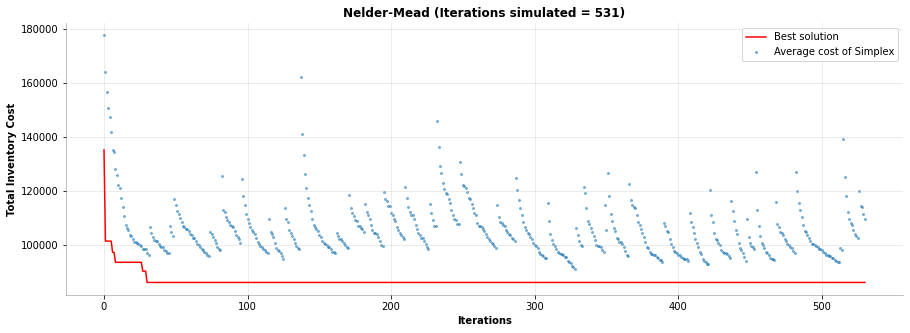

Product 0: Smin = 266.54, Smax = 525.93
Product 1: Smin = 197.18, Smax = 512.19
Product 2: Smin = 180.09, Smax = 427.28
Product 3: Smin = 261.82, Smax = 478.80
Product 4: Smin = 285.06, Smax = 692.19
Product 5: Smin = 143.88, Smax = 411.27
Product 6: Smin = 266.92, Smax = 516.83
Product 7: Smin = 282.83, Smax = 634.06
Product 8: Smin = 257.60, Smax = 409.86
Product 9: Smin = 208.39, Smax = 429.32
Simulation Started
Days simulated: 100
Simulation Ended
Performance indicators:
TIC: 98,712.85 
THC: 65,340.48  | TLC: 19,622.37  | TSC: 13,750.00  
Total Contribution Margin: 984,977.63 
SL: 98.05% 


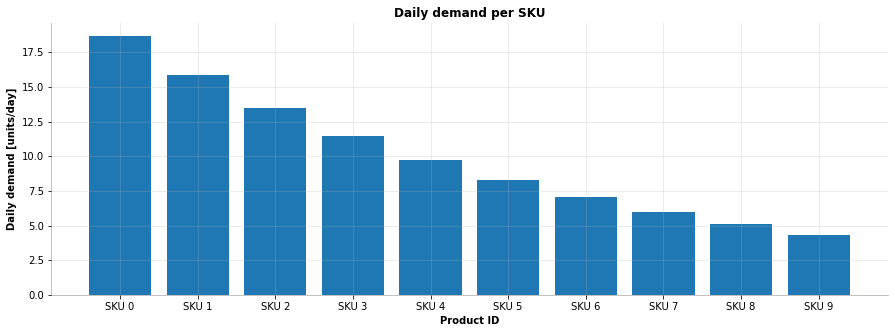

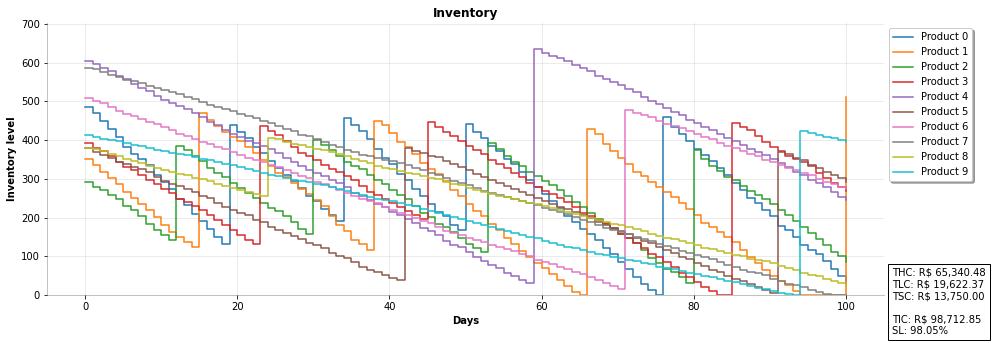

In [33]:
## Runs the SimOpt model
results_nm = nelder_mead(flags_, config_)

## Prints results
plot_evolution_best(results_nm)
print_result(results_nm, config_)


## **6) Simulating best solution**

Simulation Started
Days simulated: 100
Simulation Ended
Performance indicators:
TIC: 85,878.40 
THC: 69,628.40  | TLC: 0.00  | TSC: 16,250.00  
Total Contribution Margin: 997,600.00 
SL: 100.00% 


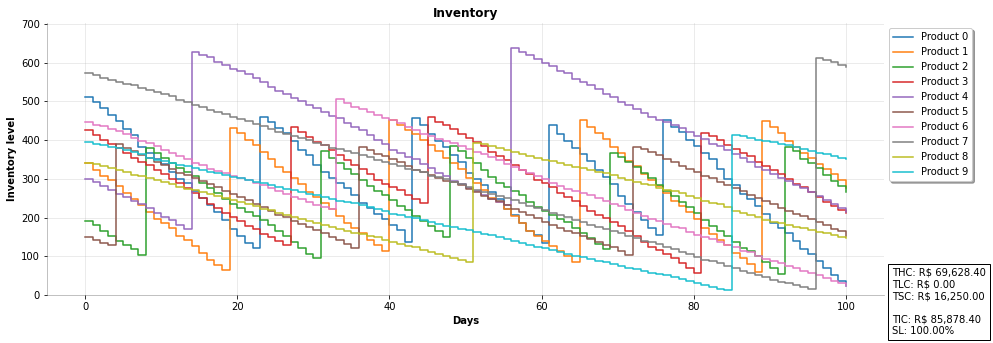

In [45]:
simulate_best(results_nm, config_)